In [171]:
import numpy as np
import pandas as pd
import random
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy import stats
import scipy.stats as st
plt.style.use('ggplot') # СТИЛЬ ДЛЯ ГРАФИКОВ

# RFMD-анализ для количественного и качественного портрета клиента


# СИНТЕЗ ДАННЫХ

In [172]:
# СОЗДАНИЕ ДАТАФРЕЙМА - СИНТЕТИЧЕСКИЕ ДАННЫЕ - ИМИТАЦИЯ НОРМАЛЬНОГО РАСПРЕДЕЛЕНИЯ

ns = 100000        # КОЛИЧЕСТВО СТРОК
n_mean = 3500      # СРЕДНЕЕ ЗНАЧЕНИЕ
n_sigma = 700     # СРЕДНЕКВАДРАТИЧЕСКОЕ ОТКЛОНЕНИЕ

syn_df = np.random.normal(n_mean, n_sigma, ns)                 # СОЗДАЕМ ДАННЫЕ
syn_df = pd.DataFrame(syn_df, columns = ["purchase"])          # ФОРМИРУЕМ ДАТАФРЕЙМ
syn_df.purchase = round(syn_df.purchase,0)                     # ПРИЧЕСЫВАЕМ

In [173]:
syn_df['user_id'] = np.random.randint ( 1, 15000, size=(100000, 1))      # ФОРМИРУЕМ СТОЛБ С ID ПОЛЬЗОВАТЕЛЕЙ
syn_df['discount'] = np.random.randint (0 , 55 , size=(100000, 1))       # СТОЛБ С РАЗМЕРОМ СКИДКИ

In [174]:
# ГЕНЕРИРУЕМ СТОЛБЕЦ С ДАТОЙ
from faker import Faker
fake = Faker()

syn_df['date'] = [fake.date_between(start_date='-1y', end_date='today') for i in range(100000)]

In [175]:
syn_df.sample(6)     # СТАРТОВЫЙ ДАТАФРЕЙМ ГОТОВ

,purchase,user_id,discount,date
2326,1562.0,6011,20,2023-12-08
18736,3678.0,10975,17,2023-12-04
99197,2291.0,673,35,2024-02-11
99828,3668.0,8448,34,2023-10-29
21976,2387.0,4129,42,2023-06-03
68924,3690.0,12066,22,2024-03-17


In [176]:
syn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   purchase  100000 non-null  float64
 1   user_id   100000 non-null  int32  
 2   discount  100000 non-null  int32  
 3   date      100000 non-null  object 
dtypes: float64(1), int32(2), object(1)
memory usage: 2.3+ MB


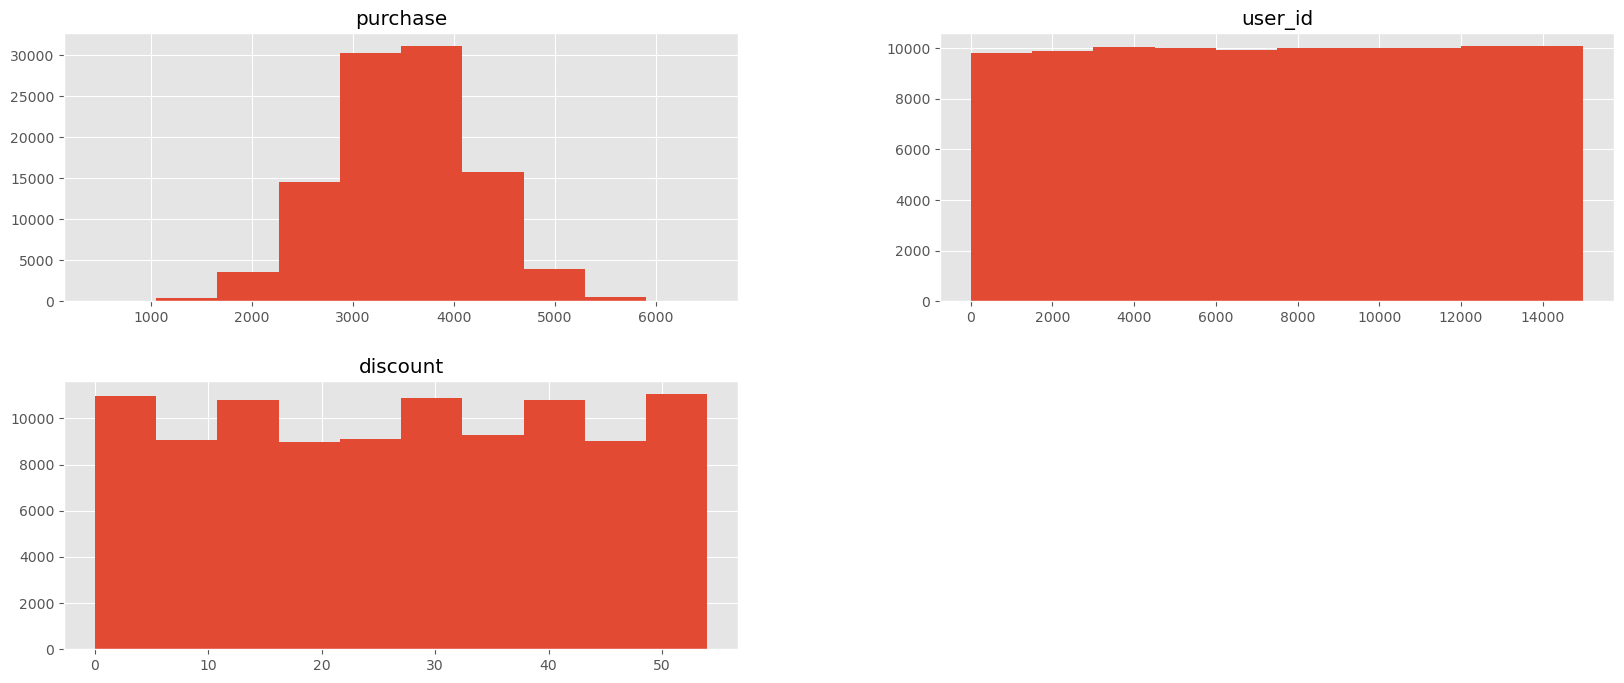

In [177]:
syn_df.hist(figsize=(20, 8));

In [178]:
# МЕНЯЕМ ФОРМАТ СТОЛБЦА НА ФОРМАТ datetime
syn_df['date'] = pd.to_datetime(syn_df['date'])

In [179]:
syn_df = syn_df.sort_values('date')              # СОРТИРУЕМ ПО ДАТЕ

In [181]:
syn_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 49791 to 69057
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   purchase  100000 non-null  float64       
 1   user_id   100000 non-null  int32         
 2   discount  100000 non-null  int32         
 3   date      100000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int32(2)
memory usage: 3.1 MB


In [182]:
syn_df.tail()

,purchase,user_id,discount,date
40805,3598.0,1676,25,2024-05-27
40800,2977.0,13711,2,2024-05-27
18774,3249.0,14782,12,2024-05-27
25256,2972.0,12394,14,2024-05-27
69057,3774.0,7786,37,2024-05-27


In [183]:
syn_df['transaction_id'] = [i+1 for i in range(100000)]        # СОЗДАЕМ СТОЛБЕЦ С НОМЕРОМ ТРАНЗАКЦИИ

In [184]:
syn_df.columns

Index(['purchase', 'user_id', 'discount', 'date', 'transaction_id'], dtype='object')

In [185]:
syn_df.head()

,purchase,user_id,discount,date,transaction_id
49791,3460.0,1218,18,2023-05-28,1
11739,3862.0,6288,6,2023-05-28,2
8788,3943.0,4582,36,2023-05-28,3
9526,4387.0,7316,35,2023-05-28,4
54602,3255.0,8772,16,2023-05-28,5


In [186]:
syn_df.to_csv('Synthetic_sales_for_RFMD_28052024.csv', sep=';')    # СОХРАНИМ

In [187]:
# АНАЛИЗ КАТЕГОРИАЛЬНЫХ СТОЛБЦОВ
syn_df.describe(include='datetime')

C:\Users\Andrey\AppData\Local\Temp\ipykernel_23512\714934493.py:2: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



,date
count,100000
unique,366
top,2023-11-22 00:00:00
freq,325
first,2023-05-28 00:00:00
last,2024-05-27 00:00:00


# RFMD-анализ

In [188]:
syn_df.date.max() # ОПРЕДЕЛЯЕМ МАКСИМАЛЬНУЮ ДАТУ ДЛЯ РАСЧЕТА ДАВНОСТИ

Timestamp('2024-05-27 00:00:00')

In [189]:
temp_df = syn_df.sort_values(['user_id', 'date'])        # СОРТИРУЕМ ПО USER и ДАТЕ, ПЕРЕЗАПИСЫВАЕМ С НОВЫМ НАЗВАНИЕМ
temp_df

,purchase,user_id,discount,date,transaction_id
18603,3417.0,1,32,2023-06-19,6165
51759,2619.0,1,45,2023-10-22,40128
39144,3373.0,1,41,2023-11-17,47447
6438,3692.0,1,1,2023-11-25,49503
99738,2228.0,1,49,2024-01-08,61503
...,...,...,...,...,...
31316,3184.0,14999,9,2023-09-24,32703
40608,3934.0,14999,53,2023-10-03,35078
64549,3847.0,14999,30,2024-01-10,62094
60093,4235.0,14999,2,2024-02-17,72529


In [190]:
# СОЗДАЕМ ДФ С ГРУППИРОВКОЙ ПО user_id и аггрегацией по полям - 
# - общая сумма покупок, дата последней покупки, средняя скидка, количество покупок

temp_df_agg = temp_df.groupby('user_id').agg(
                                              purchase_sum = ('purchase', 'sum'),
                                              purchase_amount = ('purchase', 'count'),
                                              last_purchase = ('date', 'last'),
                                              discount_avr = ('discount', 'mean')
                                             ).reset_index()

In [191]:
temp_df_agg.tail()

,user_id,purchase_sum,purchase_amount,last_purchase,discount_avr
14977,14995,29052.0,8,2024-04-13,23.500000
14978,14996,28823.0,8,2024-05-09,32.250000
14979,14997,29000.0,9,2024-05-21,20.111111
14980,14998,16008.0,4,2023-12-04,35.250000
14981,14999,28459.0,8,2024-03-25,24.250000


In [192]:
#  ДОБАВЛЯЕМ СТОЛБЕЦ С КОЛИЧЕСТВОМ ДНЕЙ ПОСЛЕ ПОСЛЕДНЕЙ ПОКУПКИ
temp_df_agg['days_since_last_purchase'] = (syn_df.date.max() - temp_df_agg['last_purchase']).dt.days
temp_df_agg.sample(3)

,user_id,purchase_sum,purchase_amount,last_purchase,discount_avr,days_since_last_purchase
8904,8918,27411.0,7,2024-04-19,16.000000,38
13284,13301,34673.0,10,2024-05-10,25.100000,17
7931,7944,32967.0,9,2024-04-22,29.111111,35


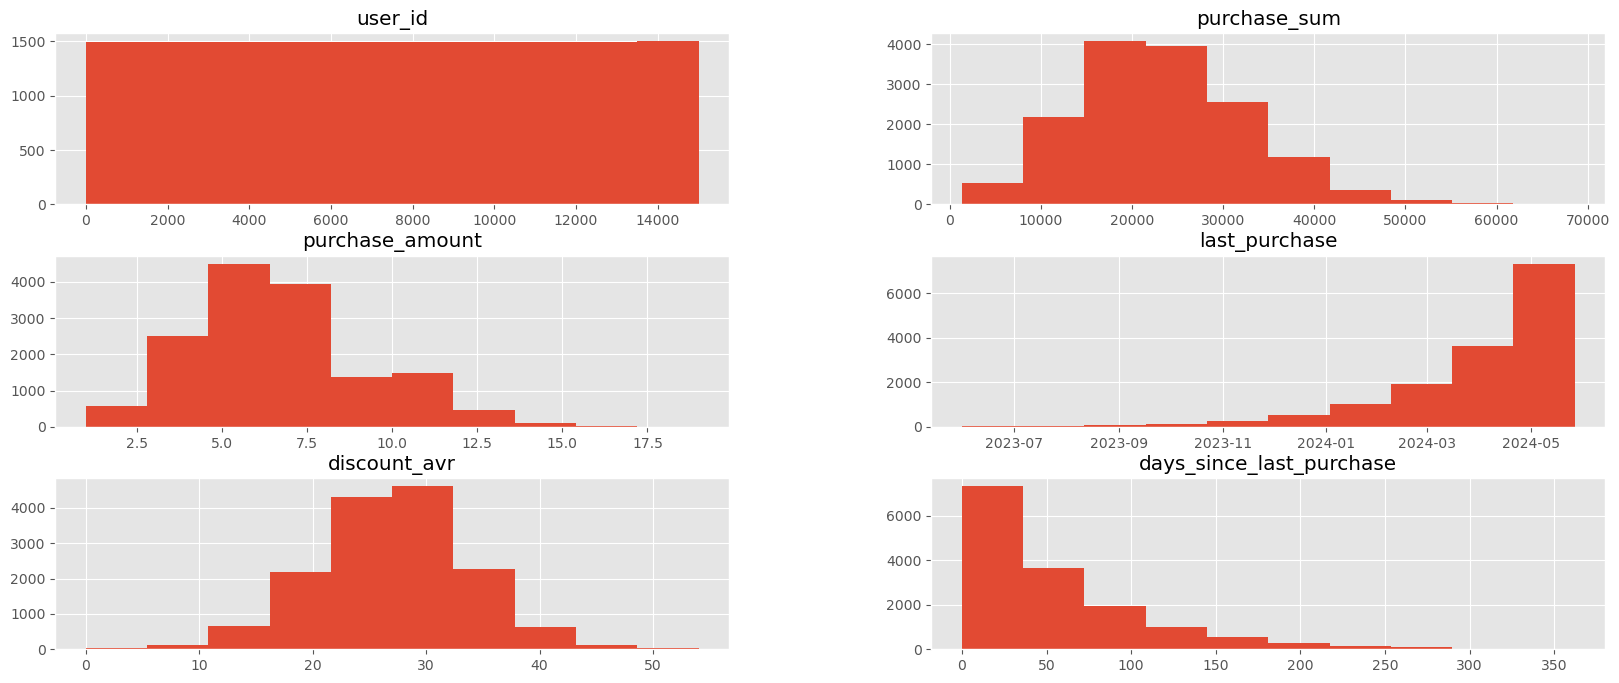

In [193]:
temp_df_agg.hist(figsize=(20, 8));

<AxesSubplot: >

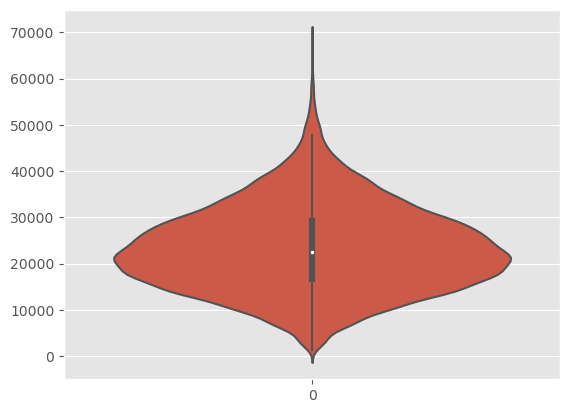

In [194]:
sns.violinplot(temp_df_agg['purchase_sum'])

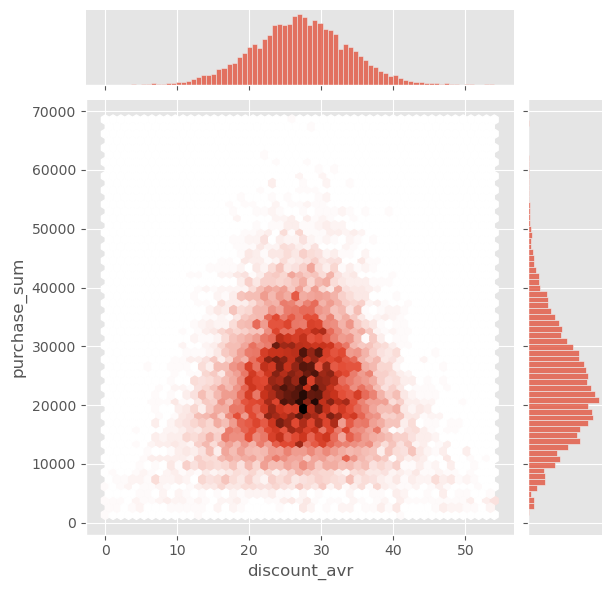

In [195]:
sns.jointplot(x='discount_avr', y='purchase_sum', data=temp_df_agg, kind='hex');

In [196]:
temp_df_agg.sample(3)

,user_id,purchase_sum,purchase_amount,last_purchase,discount_avr,days_since_last_purchase
7129,7141,25102.0,7,2024-04-13,28.857143,44
1554,1558,6790.0,2,2024-04-03,46.000000,54
7438,7450,15696.0,5,2023-11-09,26.200000,200


In [197]:
# ПЕРЕИМЕНОВЫВАЕМ СТОЛБЦЫ
temp_df_agg.rename(columns={
                            'days_since_last_purchase': 'recency', 
                            'purchase_amount': 'frequency',
                            'purchase_sum': 'monetary',
                            'discount_avr': 'discount'
                            }, inplace=True)

In [198]:
temp_df_agg.sample(3)

,user_id,monetary,frequency,last_purchase,discount,recency
9613,9627,26220.0,7,2024-05-27,24.000000,0
5248,5257,16347.0,5,2024-05-07,26.800000,20
8660,8674,20652.0,6,2024-02-17,34.333333,100


In [199]:
# ДОБАВЛЯЕМ RFMD-оценки

def set_score_R(val, comfort_line):       # ФУНКЦИЯ ДЛЯ R
  if val < comfort_line:
    return 1
  else:
    return 2

def set_score_FM(val, comfort_line):      # ФУНКЦИЯ ДЛЯ FM
  if val > comfort_line:
    return 1
  else:
    return 2

def set_score_D(val, d1, d2):             # ФУНКЦИЯ ДЛЯ D
  if val < d1:      
    return 1
  elif val < d2:
    return 2
  else:
    return 3

comfort_line = 30              # комфортная отсечка давности, дней - НЕ БОЛЬШЕ
temp_df_agg['R'] = temp_df_agg['recency'].apply(set_score_R, args=[comfort_line])

comfort_line = 6               # комфортная отсечка частоты, кол-во - НЕ МЕНЬШЕ
temp_df_agg['F'] = temp_df_agg['frequency'].apply(set_score_FM, args=[comfort_line])

comfort_line = 20000           # комфортная отсечка суммы покупок, руб. - НЕ МЕНЬШЕ
temp_df_agg['M'] = temp_df_agg['monetary'].apply(set_score_FM, args=[comfort_line])

d1 = 10                        # ОПРЕДЕЛЯЕМ ГРАНИЦЫ ДЛЯ СЕГМЕНТИРОВАНИЯ ПО РАЗМЕРУ СКИДОК, 1 - 30+%, 2 - 10-30%, 3 - до 10% 
d2 = 30                        # ОПРЕДЕЛЯЕМ ГРАНИЦЫ ДЛЯ СЕГМЕНТИРОВАНИЯ ПО РАЗМЕРУ СКИДОК, 
temp_df_agg['D'] = temp_df_agg['discount'].apply(set_score_D, args=(d1, d2))

                               # СОЕДИНИМ ВСЕ ОЦЕНКИ В ОДНУ
temp_df_agg['RFMD'] = temp_df_agg.R.map(str) + temp_df_agg.F.map(str) + temp_df_agg.M.map(str) + temp_df_agg.D.map(str)


In [200]:
temp_df_agg.head()

,user_id,monetary,frequency,last_purchase,discount,recency,R,F,M,D,RFMD
0,1,22457.0,7,2024-05-14,32.714286,13,1,1,1,3,1113
1,2,19092.0,5,2024-03-21,23.400000,67,2,2,2,2,2222
2,3,32939.0,10,2024-05-14,27.700000,13,1,1,1,2,1112
3,4,26982.0,7,2023-12-27,27.571429,152,2,1,1,2,2112
4,5,34779.0,9,2024-03-24,27.777778,64,2,1,1,2,2112


In [201]:
segments = temp_df_agg.groupby('RFMD').agg({'user_id':'count'})    # АГГРЕГИРУЕМ ПО RFMD-ГРУППАМ и СЧИТАЕМ КОЛИЧЕСТВО В КАЖДОЙ
segments = segments.reset_index()
segments.head(30)

,RFMD,user_id
0,1111,3
1,1112,2742
2,1113,1098
3,1122,5
4,1123,2
5,1211,4
6,1212,465
7,1213,248
8,1221,20
9,1222,1054


In [202]:
segments.rename(columns={'user_id': 'count'}, inplace=True)    # МЕНЯЕМ НАЗВАНИЕ СТОЛБЦА

In [203]:
# TREEMAP из библиотеки PLOTLY

fig = px.treemap(segments, path=[px.Constant('RFMD'), 'RFMD'],
                 values=segments['count'],
                 color=segments['count'],
                 color_continuous_scale='RdBu',
                 color_continuous_midpoint=np.average(segments['count'])
                )
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

In [204]:
fig = px.bar_polar(segments, r="count", theta="RFMD", color="count", template="plotly_dark",
            color_discrete_sequence= px.colors.sequential.Plasma_r)
fig.show()

# КЛАССИФИКАЦИЯ СЕГМЕНТОВ

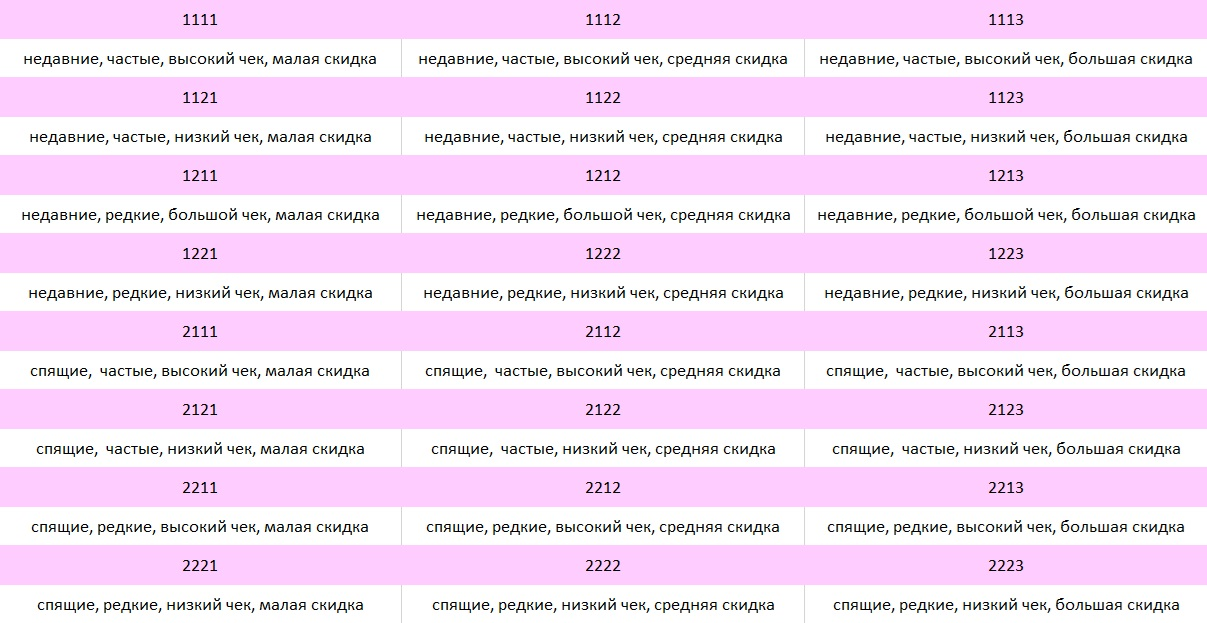

#  ВЫБОРОЧНЫЕ ВЫВОДЫ ПО ГРУППАМ:

**A.** Самые большие группы покупателей 1112, 2112, 2222. 
   
   **1112** - покупали недавно, часто, высокий средний чек, средняя скидка 10-30%.
   
   **Рекомендации:** продолжать удерживать данную группу клиентов, делать индивидуальные спецпредложения предложения на часто        покупаемые товары, побуждая приходить почаще и усиливая лояльность еще больше. Не требуют большого бюджета. 
   
   **2112** - последний раз покупали давно, но часто, высокий средний чек, средняя скидка 10-30%.
   
   **Рекомендации:** попытаться разобраться в причинах - долгого отсутствия, разработать мероприятия для возвращения покупателей
в группу 1112. Требует среднего бюджета.
   
   **2222** - покупали давно, редко, низкий чек, средняя скидка 10-30%. 
   
   **Рекомендации:** попытаться простимулировать глубокой скидкой на любимую категорию товаров на 1 месяц, попытаться вернуть
клиента и перевести хотя бы в группу 1222.   
   
**B.** Средняя по размеру группа покупателей - 2223 - покупали давно, не часто, низкий чек, с очень большим средним дисконтом.
   
   **Рекомендации:** можно использовать данную группу покупателей для слива залежавшегося товара, людей однозначно интересуют
   глубокие скидки. Обычные рассылки и напоминания о себе работать не будут.
   
**С.** Интересная средняя по размеру группа 1113. Покупали недавно, покупают часто, хороший средний чек, но очень большая средняя скидка. Это покупатель, который отлавливает глубокие спецпредложения, делает закупки впрок, либо возможно для родственников и знакомых. 

**Рекомендации:** Тратить бюджет на эту категорию - деньги на ветер. Эти клиенты лучше многих в компании знают когда скидки, насколько большие и как часто можно отловить тот или иной товар. Даже слив залежалых остатков им рекламировать не нужно, они сами обо всем узнают.